In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import pandas as pd
import collections
import lqg1d
import json

import numba

In [2]:
def load_dataframe(folder):
    experiments = []
    for experiment in glob.glob(os.path.join(folder, '*_params.json')):
        with open(experiment, 'r') as f:
            params = json.load(f)

        experiments.append({k.upper():i for k,i in params.items()})
    experiments_df = pd.DataFrame(experiments)
    experiments_df = experiments_df.fillna('-')
    
    return experiments_df

In [3]:
def load_from_dataframe(df):
    return [pd.read_pickle(f + '.gzip') for f in df['FILENAME'].values]
        

In [4]:
def filter_experiments(**kwargs):
    df_filtered = kwargs['df']
    for k,v in kwargs.items():
        if v is not None:
            try:
                if isinstance(v, list):
                    df_filtered = df_filtered[df_filtered[k.upper()].isin(v)]
                else:
                    df_filtered = df_filtered[df_filtered[k.upper()] == v]
            except:
                pass
    return df_filtered

In [5]:
def my_plot(**kwargs):
    data_params = filter_experiments(**kwargs)
    
    free_vars = []
    for k,v in kwargs.items():
        if v is None or (k.upper() in data_params.columns and isinstance(v, list)):
            free_vars.append(k)

    free_vars = [s.upper() for s in free_vars]
    
    if len(free_vars) <= 0:
        data_params = data_params.sort_values(by=list(data_params.columns))
    else:
        data_params = data_params.sort_values(by=free_vars)

    data = load_from_dataframe(data_params)

    plt.rcParams["figure.figsize"] = (15,13)
    
    def plot_lines(**kwargs):
        if 'max_t' in kwargs:
            MAX_T = kwargs['max_t']
        else:
            MAX_T = -1
        
        if 'min_t' in kwargs:
            MIN_T = kwargs['min_t']
        else:
            MIN_T = 0

        if isinstance(kwargs['value'], list):
            params = kwargs
            ll = len(kwargs['value'])
            i = 1
            for v in kwargs['value']:
                plt.subplot((ll + 1)//2, 2, i)
                i+=1
                params['value'] = v
                plot_lines(**params)
        else:
            for d in data:
                try:
                    x = d['T'].values[MIN_T:MAX_T]
                    y = d[kwargs['value']].values[MIN_T:MAX_T]
                except:
                    x = d['T'].values[MIN_T:MAX_T]
                    y = np.zeros(x.shape[0])
                plt.plot(x, y)
                plt.xlabel('Timesteps')
                plt.ylabel(kwargs['value'])
                plt.title(kwargs['value'])

    plot_lines(**kwargs)
    
    # Build legend

    legend = [' '.join(map(lambda x : ': '.join((x[0], x[1] if x[1] is not np.nan else '-')), zip(data_params.loc[:,free_vars].columns.values, s))) for s in data_params.loc[:,free_vars].values]

    plt.legend(legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        

# Load experiments

In [11]:
BASE_FOLDER = 'experiments'

experiments_df = load_dataframe(BASE_FOLDER)

## Results

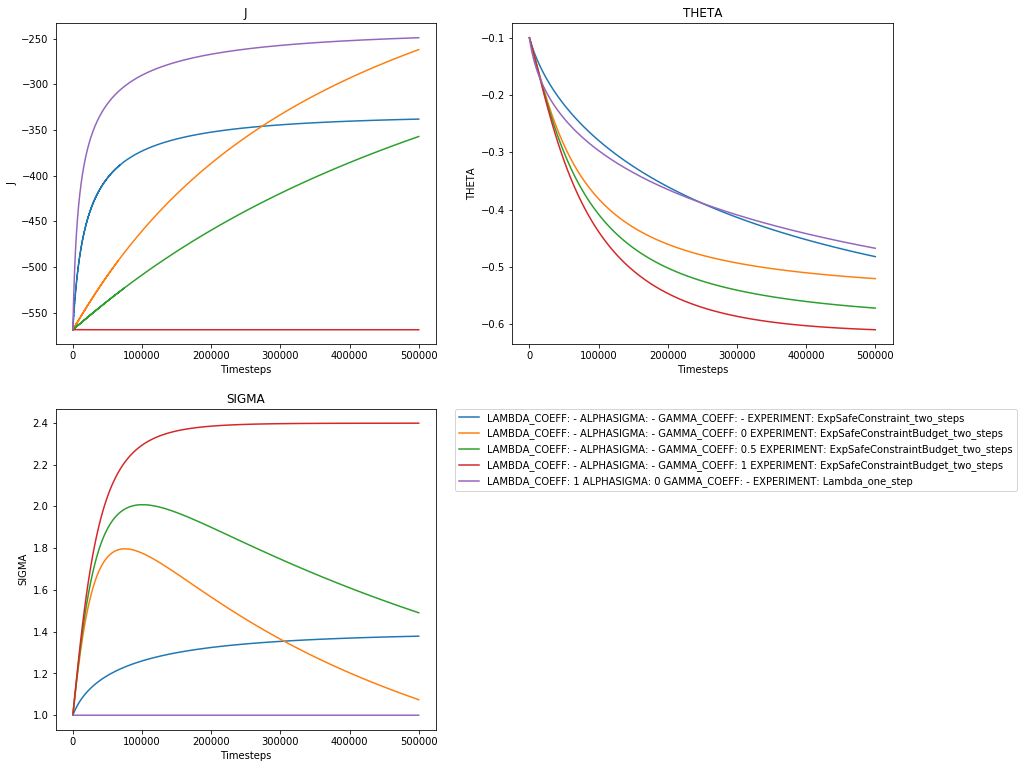

In [8]:
my_plot(lambda_coeff=['-', '1'], 
        theta='-0.1', 
        alphaSigma = ['-', '0'], 
        gamma_coeff = ['0', '0.5','1','-'],
        experiment=['ExpSafeConstraintBudget_two_steps', 'Lambda_one_step', 'ExpSafeConstraint_two_steps'],
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        min_t = 0,
        max_t = -1,
        df = experiments_df)

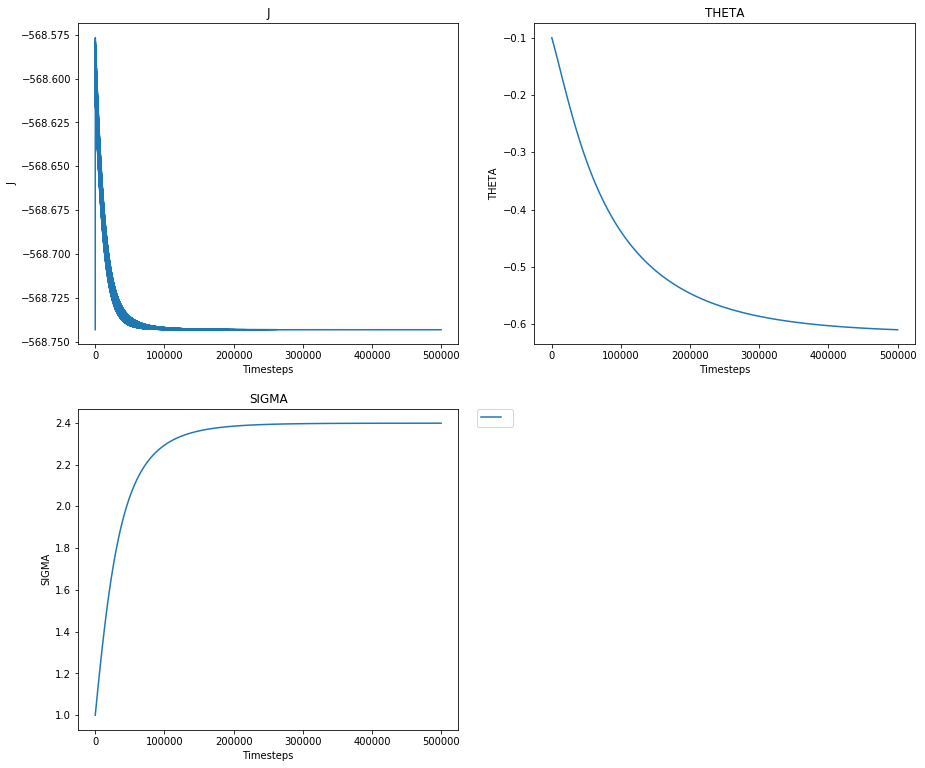

In [9]:
my_plot(lambda_coeff='-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpSafeConstraintBaseline_two_steps',
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        max_t=-1,
        df = experiments_df)

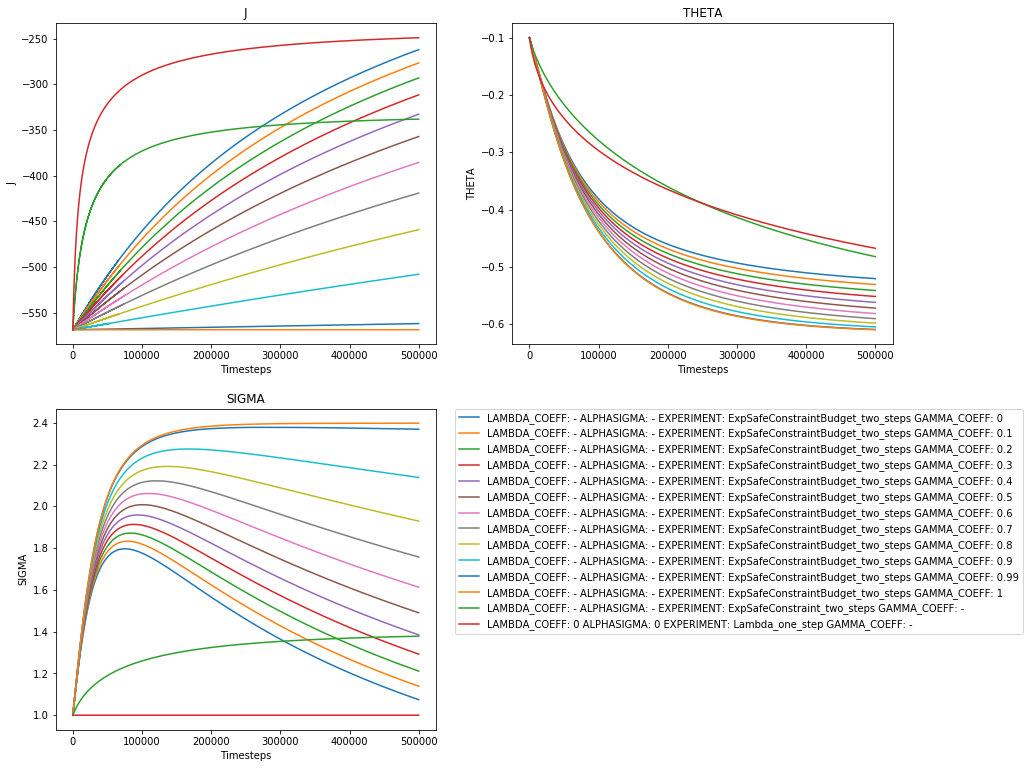

In [10]:
my_plot(lambda_coeff = ['-', '0'], 
        theta='-0.1', 
        alphaSigma = ['-', '0'], 
        experiment=['ExpSafeConstraintBudget_two_steps', 'ExpSafeConstraint_two_steps', 'Lambda_one_step'],
        gamma_coeff=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        max_t=-1,
        df = experiments_df)

# Experiments long

In [15]:
BASE_FOLDER = 'experiments_long'

experiments_df = load_dataframe(BASE_FOLDER)

## Results

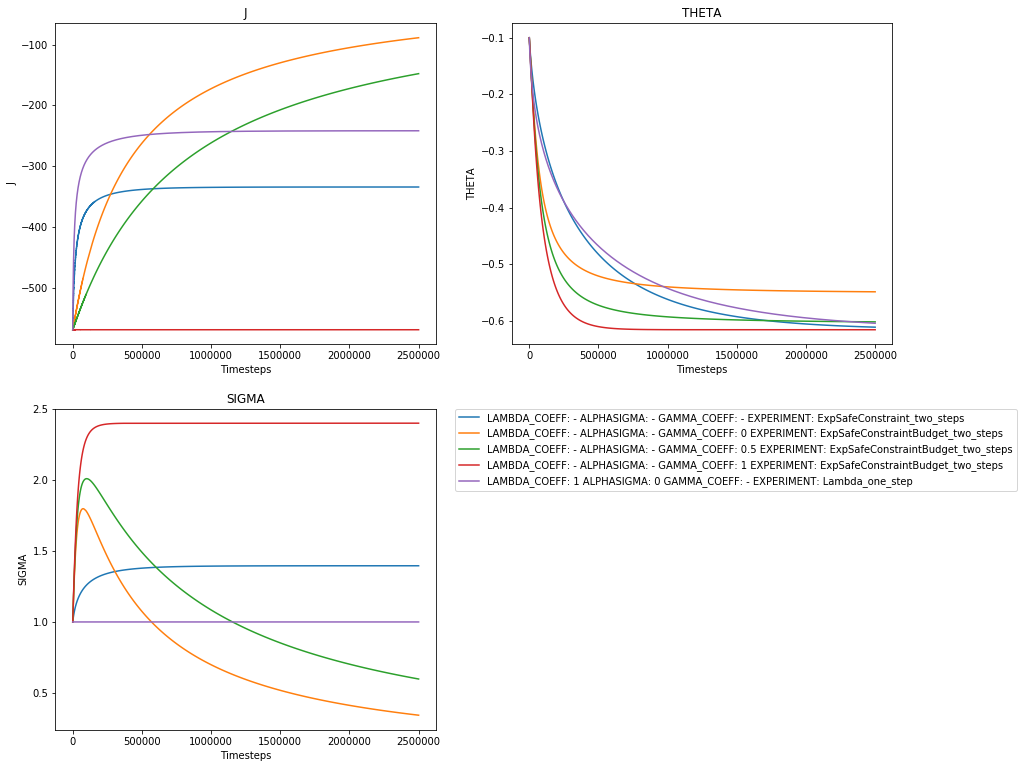

In [16]:
my_plot(lambda_coeff=['-', '1'], 
        theta='-0.1', 
        alphaSigma = ['-', '0'], 
        gamma_coeff = ['0', '0.5','1','-'],
        experiment=['ExpSafeConstraintBudget_two_steps', 'Lambda_one_step', 'ExpSafeConstraint_two_steps'],
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        min_t = 0,
        max_t = -1,
        df = experiments_df)

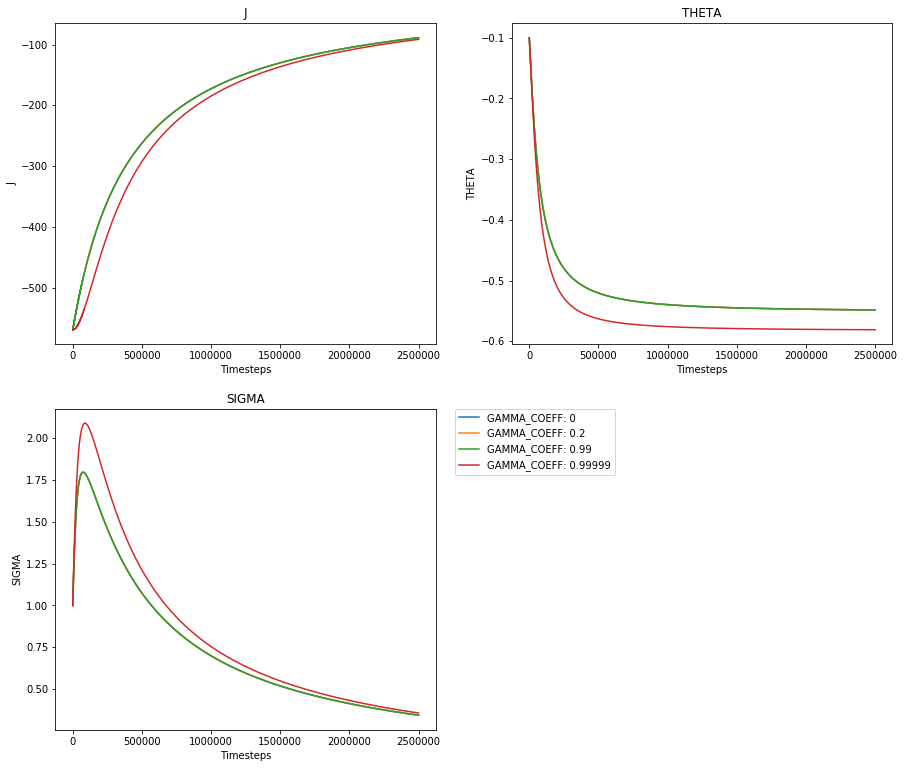

In [20]:
my_plot(lambda_coeff='-', 
        theta='-0.1', 
        alphaSigma = '-', 
        gamma_coeff = ['0', '0.2', '0.99', '0.99999'],
        experiment='ExpSafeConstraintBudget_new',
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        min_t = 0,
        max_t = -1,
        df = experiments_df)

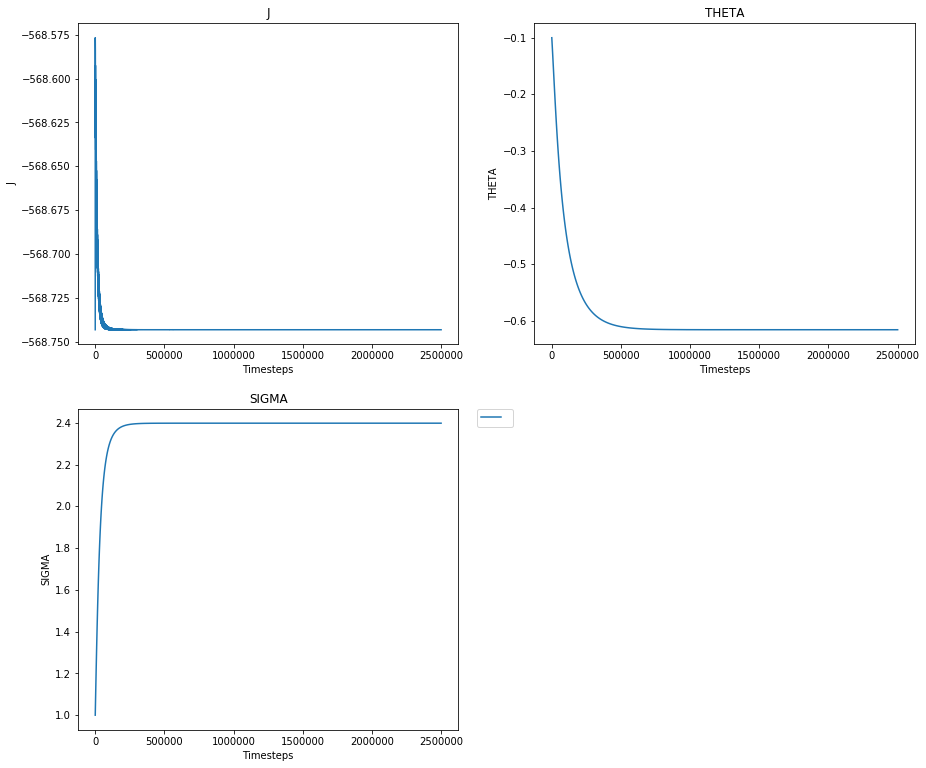

In [14]:
my_plot(lambda_coeff='-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpSafeConstraintBaseline_two_steps',
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        max_t=-1,
        df = experiments_df)

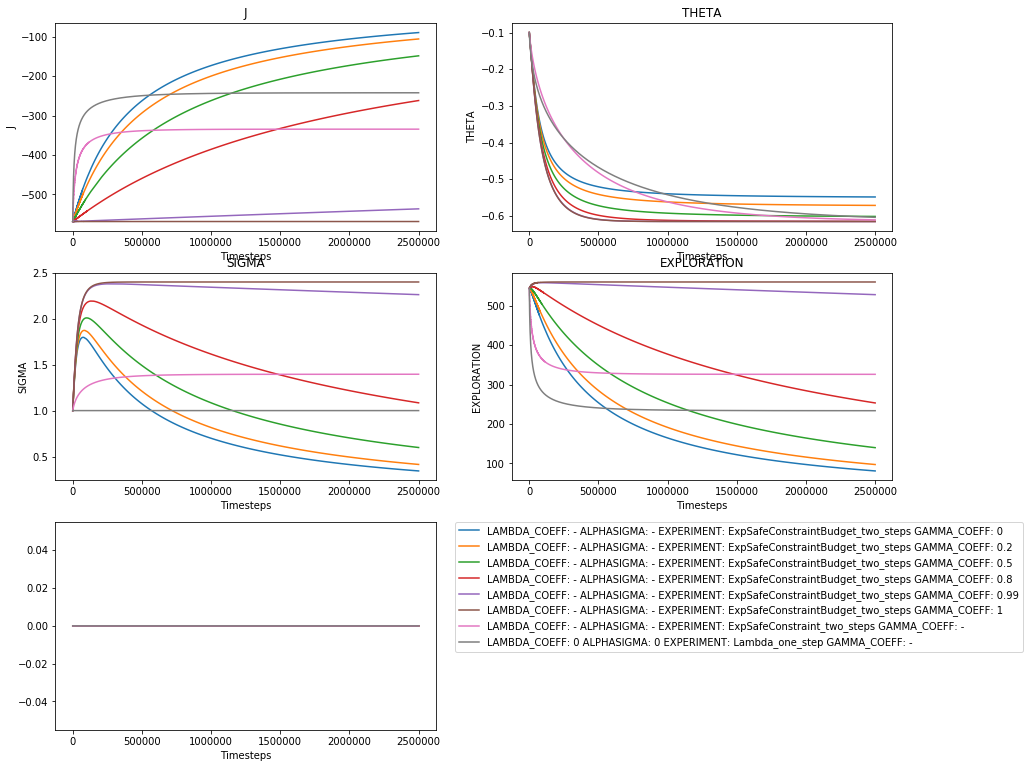

In [188]:
my_plot(lambda_coeff = ['-', '0'], 
        theta='-0.1', 
        alphaSigma = ['-', '0'], 
        experiment=['ExpSafeConstraintBudget_two_steps', 'ExpSafeConstraint_two_steps', 'Lambda_one_step'],
        gamma_coeff=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION', ''], 
        max_t=-1,
        df = experiments_df)

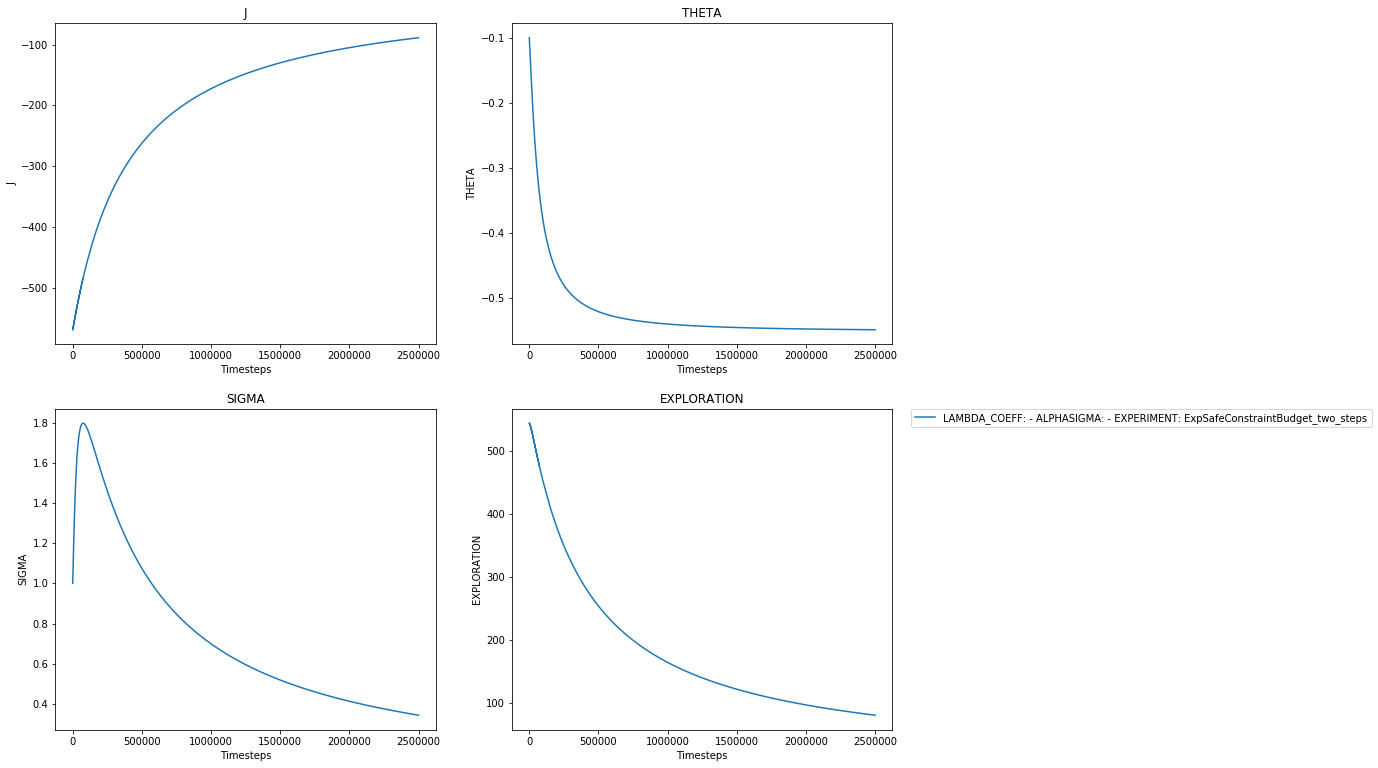

In [16]:
my_plot(lambda_coeff = ['-'], 
        theta='-0.1', 
        alphaSigma = ['-'], 
        experiment=['ExpSafeConstraintBudget_two_steps'],
        gamma_coeff='0',
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION'], 
        max_t=-1,
        df = experiments_df)

# Experiments

In [71]:
experiments_df_2 = load_dataframe('exploration_cost_exp')

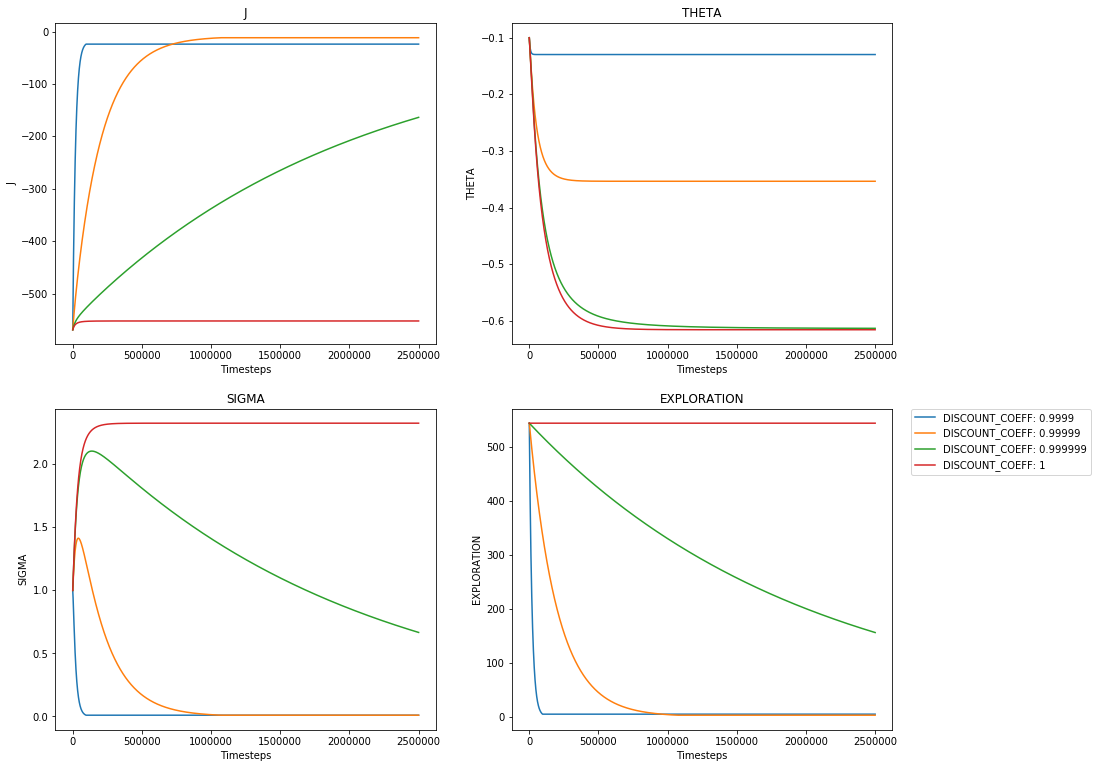

In [42]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpExplorationCost_two_steps',
        gamma_coeff='-',
        discount_coeff=None,
        init_exp = '-1',
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION'], 
        max_t=-1,
        df = experiments_df_2)

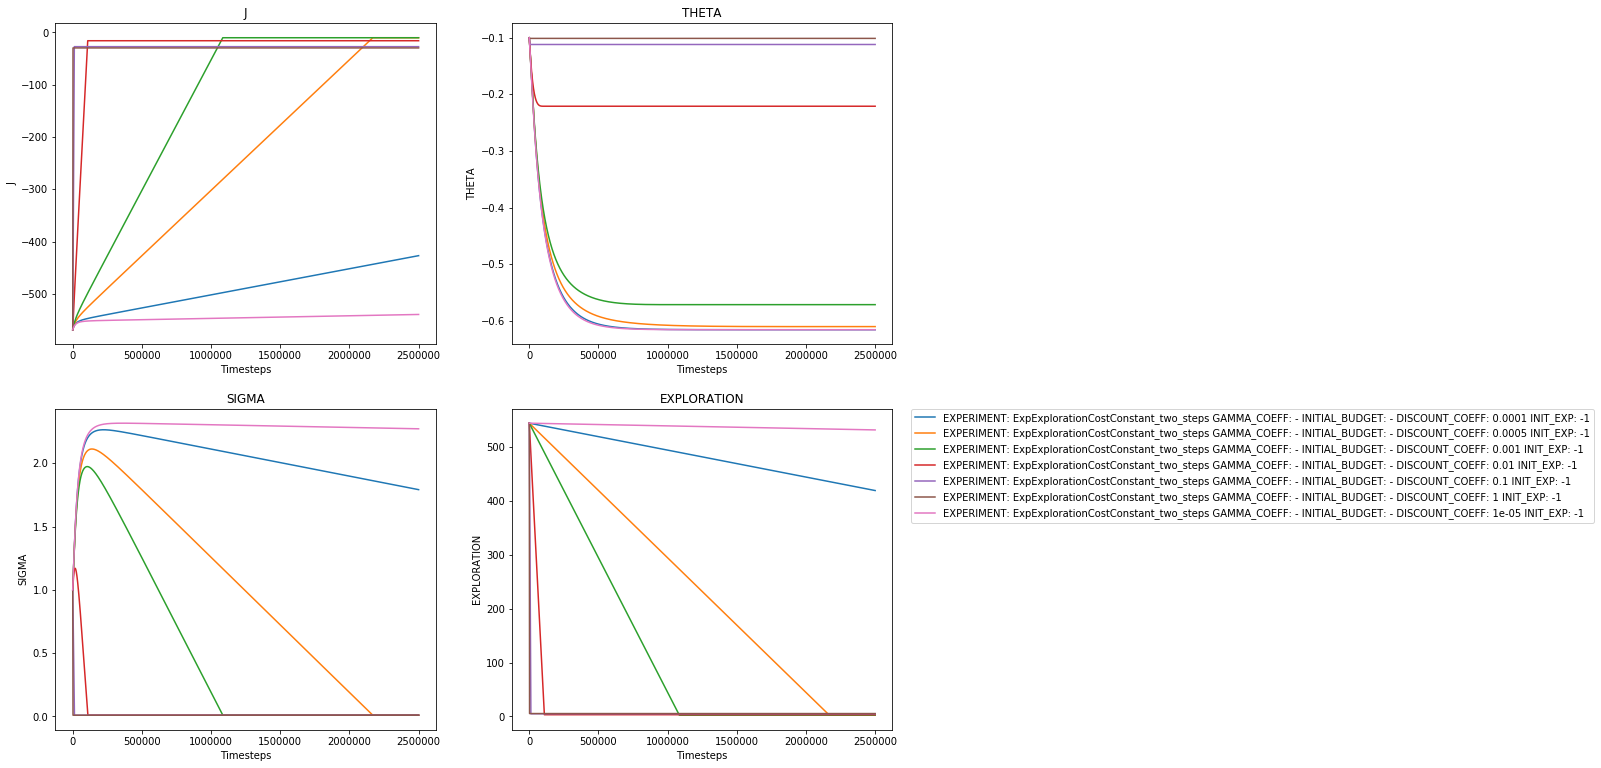

In [72]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment=['ExpExplorationCostConstant_two_steps'],
        gamma_coeff=None,
        initial_budget=None,
        discount_coeff=None,
        init_exp = None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION'], 
        max_t=-1,
        df = experiments_df_2)

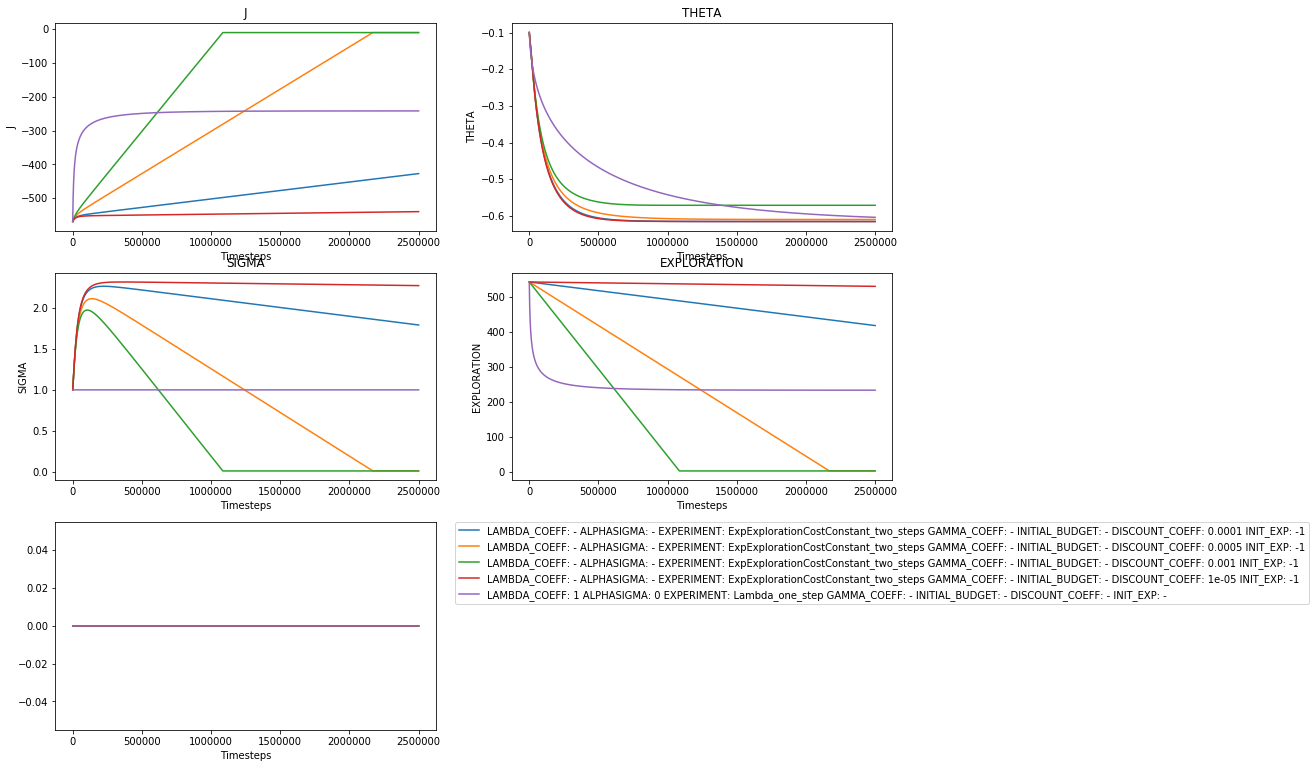

In [80]:
my_plot(lambda_coeff = ['-', '1'], 
        theta='-0.1', 
        alphaSigma = ['-', '0'] ,
        experiment=['ExpExplorationCostConstant_two_steps', 'Lambda_one_step'],
        gamma_coeff=None,
        initial_budget=None,
        discount_coeff=['0.0001', '0.0005', '0.001', '1e-05', '-'],
        init_exp = None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION', ''], 
        max_t=-1,
        df = pd.concat([experiments_df_2, experiments_df]).fillna('-'))

# Comparison between budget and exploration

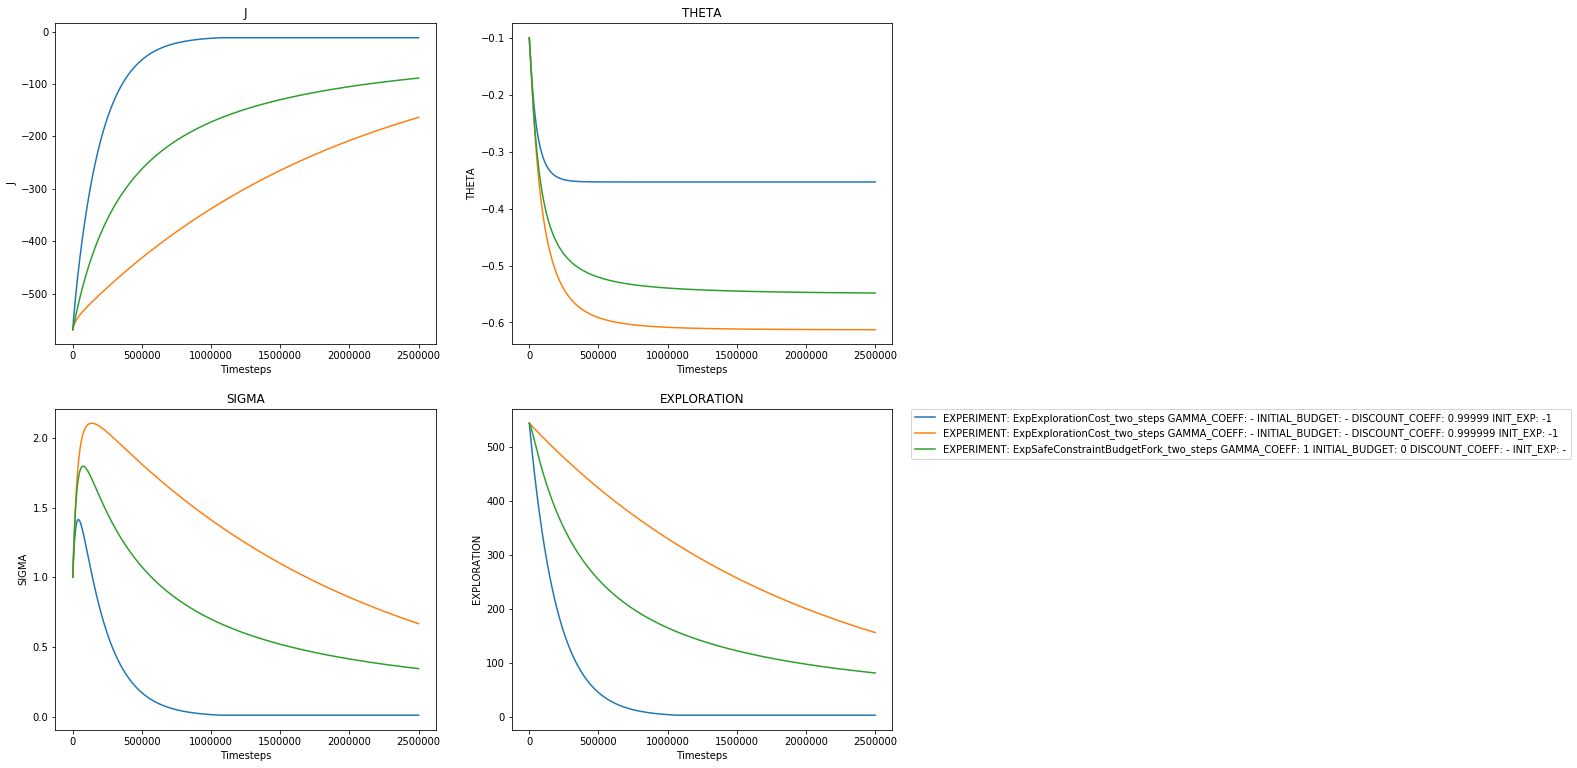

In [59]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment=['ExpSafeConstraintBudgetFork_two_steps','ExpExplorationCost_two_steps'],
        gamma_coeff=['-', '1'],
        initial_budget=['-', '0'],
        discount_coeff=['-', '0.99999', '0.999999'],
        init_exp = ['-', '-1'],
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION'], 
        max_t=-1,
        df = experiments_df_2)

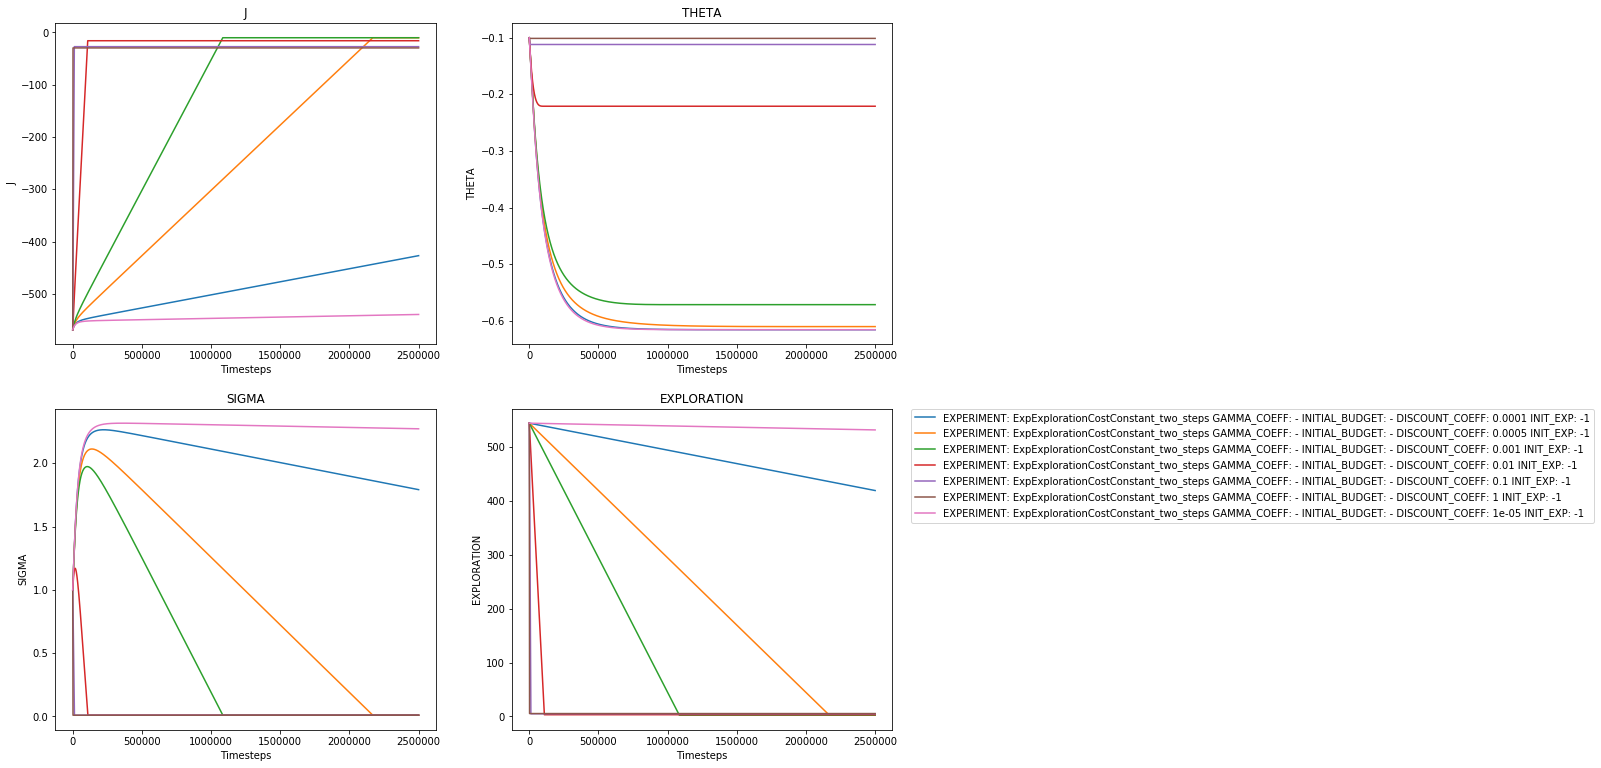

In [69]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment=['ExpExplorationCostConstant_two_steps'],
        gamma_coeff=None,
        initial_budget=None,
        discount_coeff=None,
        init_exp = None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION'], 
        max_t=-1,
        df = asdf)

In [73]:
prova_df = load_dataframe('prova/')

In [74]:
asdf = pd.concat([prova_df, load_dataframe('prova2/')]).fillna('-')

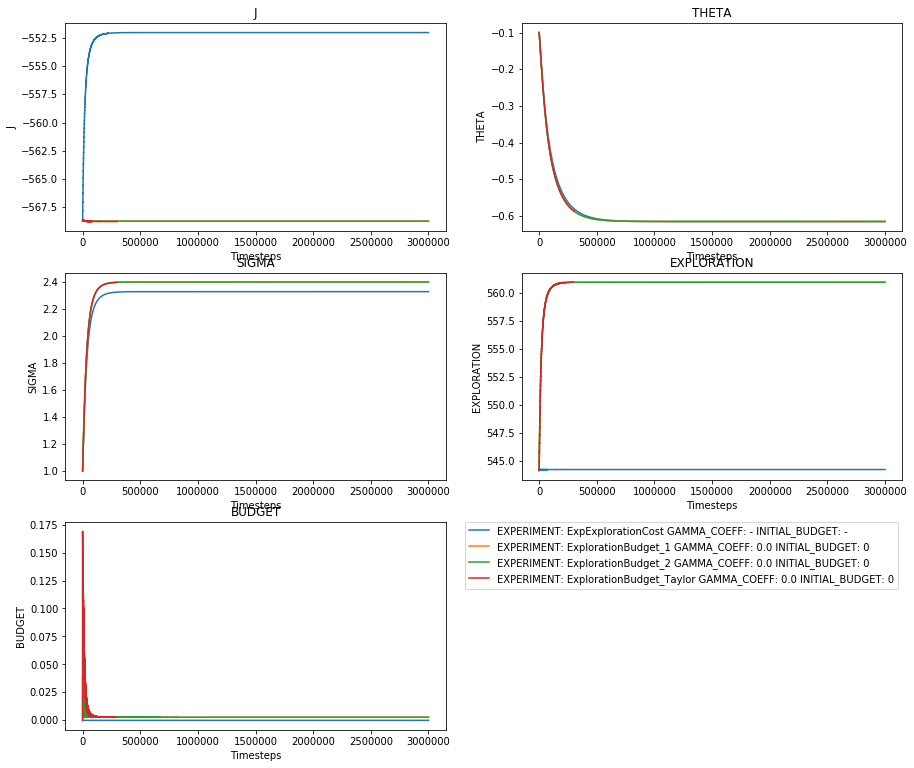

In [75]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment=None,
        gamma_coeff=None,
        initial_budget=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION', 'BUDGET'], 
        max_t=-1,
        df = asdf)

In [104]:
prova_df = load_dataframe('prova2/')

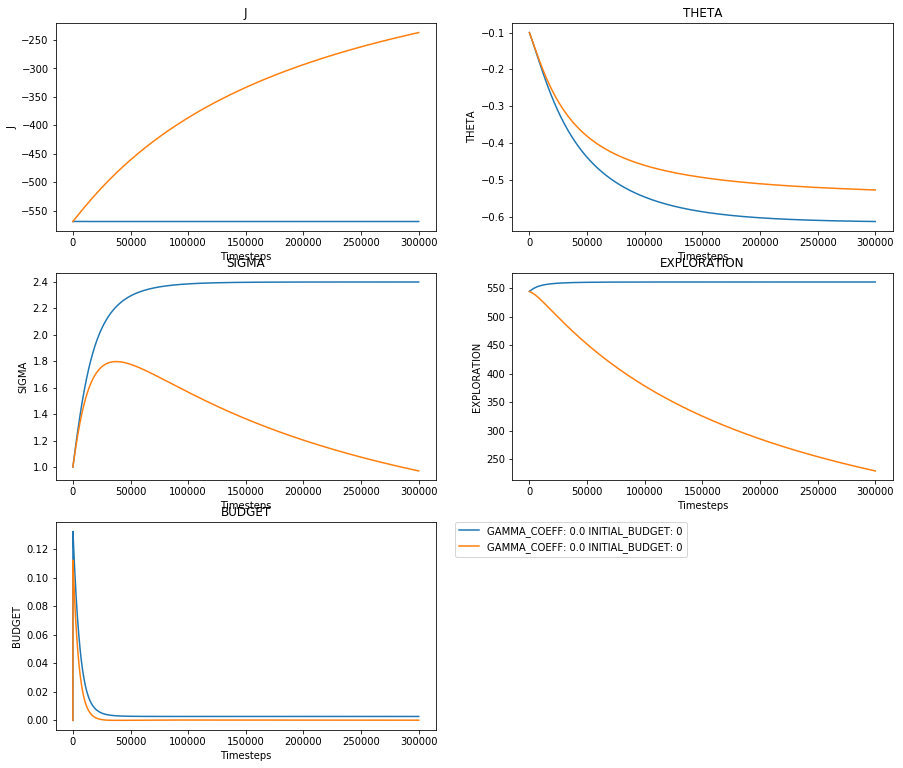

In [105]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpSafeConstraintBudgetFork',
        gamma_coeff=None,
        initial_budget=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION', 'BUDGET'], 
        max_t=-1,
        df = prova_df)

In [106]:
lqg = lqg1d.LQG1D()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [110]:
lqg.grad_K(-0.2, 1.5)

-1547.764392364752

In [111]:
lqg.grad_K(-0.2, 0)

-53.6603039606415

In [113]:
lqg.grad_Sigma(-0.2, 1.5)

-342.9039301310041

In [115]:
lqg.computeJ(-0.2, 1.5)

-527.9803493449778

In [116]:
lqg.computeJ(-0.2, 0) - lqg.computeJ(-0.2, 1.5)

514.3558951965061

In [178]:
THETA = -0.2
SIGMA = 0.7

step_theta = -1e-10
step_sigma = 1e-10

alpha_sigma = step_sigma / lqg.grad_Sigma(THETA, SIGMA)
alpha_theta = step_theta / lqg.grad_K(THETA, SIGMA)

In [179]:
exp_cost = lqg.computeJ(THETA, 0) - lqg.computeJ(THETA, SIGMA)

In [180]:
exp_cost_after = lqg.computeJ(THETA + step_theta, 0) - lqg.computeJ(THETA + step_theta, SIGMA + step_sigma)

In [181]:
exp_cost - exp_cost_after

3.543448201526189e-08

In [182]:
estimation = -alpha_theta * (lqg.grad_K(THETA, 0))**2 + alpha_theta * (lqg.grad_K(THETA, SIGMA))**2 + alpha_sigma * (lqg.grad_Sigma(THETA, SIGMA))**2
estimation

4.0417035769303134e-08